#第二節課 - 實作 Human Pose Estimation Model

|<font size=5>Input Image</font>|<font size=5>Result 1-1</font>|<font size=5>Result 1-2</font>|
|  :----:  | :----:  |:----:  |
|<img src="https://i.imgur.com/BGJ3jTN.jpg" width="150" height="150" align="middle" />|![](https://i.imgur.com/yKglbXb.png)|![](https://i.imgur.com/qf2X75m.png)|

##Import Model / Load package


In [ ]:
!pip install scipy
!pip install tabulate
!pip install matplotlib
!pip install dataclasses
!pip install opencv-python
!pip install importlib-resources
!pip install pytorch-stacked-hourglass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 35.7 MB/s 


##Import package,Funtion
[pytorch-stacked-hourglass](https://github.com/anibali/pytorch-stacked-hourglass/tree/master/src/stacked_hourglass)

In [ ]:
from stacked_hourglass.utils.evaluation import final_preds_untransformed
from stacked_hourglass import HumanPosePredictor, hg1,hg2,hg8

from stacked_hourglass.datasets.mpii import MPII_JOINT_NAMES

from google.colab import files

import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
import cv2,torch
import math 

##Download  weight

In [ ]:
#設定模型權重:hg1、hg2、hg8
model = hg2(pretrained=True)
# 執行階段需設定為 "GPU"，device='cuda'
predictor = HumanPosePredictor(model, device='cuda')

Downloading: "https://github.com/anibali/pytorch-stacked-hourglass/releases/download/v0.0.0/bearpaw_hg2-15e342d9.pth" to /root/.cache/torch/hub/checkpoints/bearpaw_hg2-15e342d9.pth


  0%|          | 0.00/25.9M [00:00<?, ?B/s]

## pytorch-stacked-hourglass 檢測關鍵點

```
# 0 right_ankle   # 4 left_knee     # 8 neck            # 12 right_shoulder
# 1 right_knee    # 5 left_ankle    # 9 head_top        # 13 left_shoulder
# 2 right_hip     # 6 pelvis        # 10 right_wrist    # 14 left_elbow
# 3 left_hip      # 7 spine         # 11 right_elbow    # 15 left_wrist


```

##Define Funtion

In [ ]:
#Resize圖像
def calculate_fit_contain_output_area(in_height, in_width, out_height, out_width):
    ih, iw = in_height, in_width
    k = min(out_width / iw, out_height / ih)
    oh = round(k * ih)
    ow = round(k * iw)
    y_off = (out_height - oh) // 2
    x_off = (out_width - ow) // 2
    return y_off, x_off, oh, ow

In [ ]:
#計算脊椎關鍵點
def estimate_joints(image,heatmaps, flip=False):
  input_shape = (512, 512)
  raw_images = image
  heatmaps = heatmaps.unsqueeze(0)
  raw_images = raw_images.unsqueeze(0)
  heatmaps = heatmaps.cpu()
 
  coords = final_preds_untransformed(heatmaps, heatmaps.shape[-2:][::-1])
  # Rescale coords to pixel space of specified images.
  for i, image in enumerate(raw_images):
      y_off, x_off, height, width = calculate_fit_contain_output_area(*image.shape[-2:], *input_shape)
      coords[i, :, 1] *= input_shape[-2] / heatmaps.shape[-2]
      coords[i, :, 1] -= y_off
      coords[i, :, 1] *= image.shape[-2] / height
      coords[i, :, 0] *= input_shape[-1] / heatmaps.shape[-1]
      coords[i, :, 0] -= x_off
      coords[i, :, 0] *= image.shape[-1] / width
  return coords

In [ ]:
def draw_human_joints(img, joints):
  for i in range(0, 16):
    if (int(joints[0][i][0]) != 0 and int(joints[0][i][1]) != 0):
      if (i >= 7 and i <= 9 or i >= 12 and i <= 13):
        img = cv2.circle(img, (int(joints[0][i][0]),int(joints[0][i][1])), 
          10, (200, 255, 0), thickness=-1, lineType=8)
      else:  
        img = cv2.circle(img, (int(joints[0][i][0]),int(joints[0][i][1])), 
          10, (0, 255, 240), thickness=-1, lineType=8)
    
  return img

##Upload Image Image /  preprocessing

In [ ]:
#清除目前資料夾中的jpg圖檔，避免圖片重複上傳
%cd /content/
!ls | grep *.jpg | xargs rm -rf

/content


In [ ]:
#下載範例檔圖片
!gdown "1oW0f4NjAhp48Ib2SAm1DxWcVBJZrYYAm" -O example.jpg

Downloading...
From: https://drive.google.com/uc?id=1oW0f4NjAhp48Ib2SAm1DxWcVBJZrYYAm
To: /content/example.jpg
100% 25.7k/25.7k [00:00<00:00, 20.4MB/s]


In [ ]:
"""#上傳本機端圖片
image = files.upload() #不建議使用背景佔比超過40%的圖像"""

Saving 001.jpg to 001.jpg


In [ ]:
#讀取上傳影像
"""#本機端圖片
image = Image.open(list(image.keys())[0])"""

#範例檔圖片
image = Image.open("example.jpg")

In [ ]:
#影像前處理
image_resize = image.resize((512, 512))
image_np = np.array(image)

raw_img = image_np.copy()
image_np = np.transpose(image, (2,0,1))
image_tensor = torch.from_numpy(image_np) 

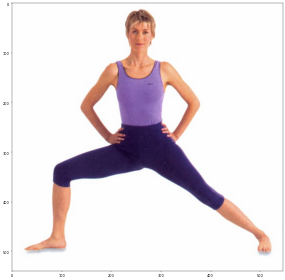

In [ ]:
plt.figure(figsize=(14,20),dpi=25)
plt.imshow(image)
plt.show()

##Output Heatmaps / Estimation  Human Joints

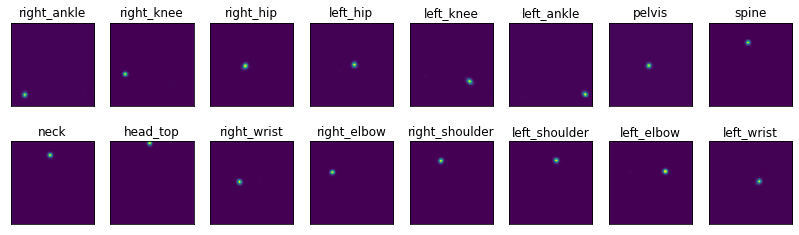

In [ ]:
heatmaps = predictor.estimate_heatmaps(image_tensor, flip=False) 
plt.figure(figsize = (14,4))

for i in range(0, 16):

#將多張結果圖顯示在一張影像中 plt.subplot(列數,行數,第幾行),plt.title(每張結果圖的標題文字)
#不顯示x,y座標 plt.xticks([]),plt.yticks([])
  plt.subplot(2,8,i+1)
  plt.title(MPII_JOINT_NAMES[i])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(heatmaps[i])
plt.show()

In [ ]:
joints = estimate_joints(image_tensor,heatmaps, flip=True)

for i,name in enumerate(MPII_JOINT_NAMES):
  print(name, joints[0][i].tolist())

right_ankle [91.7109375, 468.4980163574219]
right_knee [100.2421875, 336.1659851074219]
right_hip [228.2109375, 284.9407043457031]
left_hip [287.9296875, 276.40313720703125]
left_knee [390.3046875, 383.12249755859375]
left_ankle [496.9453125, 468.4980163574219]
pelvis [258.0703125, 280.67193603515625]
spine [253.8046875, 131.2648162841797]
neck [253.8046875, 97.11461639404297]
head_top [258.0703125, 16.007904052734375]
right_wrist [194.0859375, 267.8656005859375]
right_elbow [147.1640625, 208.10275268554688]
right_shoulder [202.6171875, 131.2648162841797]
left_shoulder [309.2578125, 131.2648162841797]
left_elbow [364.7109375, 199.56520080566406]
left_wrist [326.3203125, 263.5968322753906]


##Show Result Image

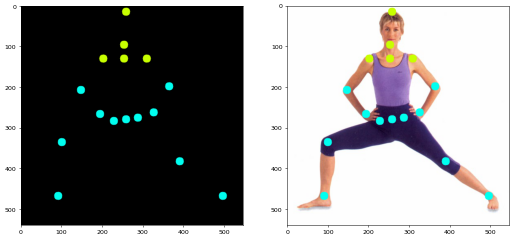

In [ ]:
w,h = image.size

plt.figure(figsize=(14,20),dpi= 45)
#印出16個關鍵點

img_point = np.zeros((h,w,3), np.uint8)
img_point = draw_human_joints(img_point,joints)


plt.subplot(1,2,1)
plt.imshow(img_point)

#印出16個關鍵點至原圖
img_res = raw_img.copy()
img_res = draw_human_joints(img_res,joints)

plt.subplot(1,2,2)
plt.imshow(img_res)


plt.show()

#第三節課 - 運用 Human Pose Estimation Model 來檢測

|<font size=5>Input Image</font>|<font size=5>Result</font>|
|:---:|:---:|
|<img src="https://i.imgur.com/mZapmNh.png" width="250" height="250" align="middle" />|<img src="https://i.imgur.com/kzqBa14.png" width="250" height="250" align="middle" />|

##Define Funtion

In [ ]:
#計算關鍵點間的角度
def arccos_angle(p1, p2):
    distance = (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2
    a = np.sqrt([distance])
    theta = np.sqrt([(p1[0] - p2[0])**2]) / a
    degree = np.arccos(theta) * 180 / np.pi
    return degree 

In [ ]:
def draw_line(img, joints):
  if joints.shape[1] ==4 : 
    for i in range (0,2):
      for j in range (0,2):
        img = cv2.line(img,(joints[0][i],joints[1][i]),(joints[0][j],
                  joints[1][j]),(200,0,200),thickness=2)
    
    for i in range (2,4):
      for j in range (2,4):
        img = cv2.line(img,(joints[0][i],joints[1][i]),(joints[0][j],
                  joints[1][j]),(200,0,200),thickness=2)
    return img
  else :
    for i in range (0,2):
      for j in range (0,2):
        img = cv2.line(img,(joints[0][i],joints[1][i]),(joints[0][j],
                  joints[1][j]),(255,204,255),thickness=4)
    for i in range (1,3):
      for j in range (1,3):
        img = cv2.line(img,(joints[0][i],joints[1][i]),(joints[0][j],
                  joints[1][j]),(255,255,0),thickness=4)
    return img

##讀取關鍵點數據並計算頭部偏移角度

In [ ]:
#取對應關鍵點數據
joint_list = [[],[]]
for i in range (7,10,2):
  joint_list[0].append(int(joints[0][i][0]))
  joint_list[1].append(int(joints[0][i][1]))
for i in range (12,14):
  joint_list[0].append(int(joints[0][i][0]))
  joint_list[1].append(int(joints[0][i][1]))
joint_arr = np.array(joint_list)

In [ ]:
v1_ang = math.floor(arccos_angle(joint_arr[:,0],joint_arr[:,1]))

##將關鍵點連線後顯示結果

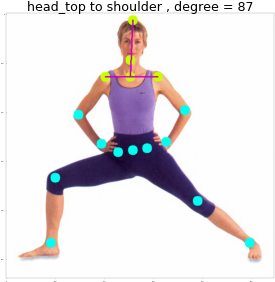

In [ ]:
#將結果印回原圖
Angle = "head_top to shoulder , degree = " + str(v1_ang) 
res = img_res.copy()
res = draw_line(img_res, joint_arr)

plt.figure(figsize=(w/20,h/20),dpi=13)

plt.title(Angle,fontsize=70)
plt.imshow(res)

plt.show()

#第四堂課 實作側身脊椎5點檢測

|<font size=5>Input Image 1</font>|<font size=5>Result 1</font>|<font size=5>Input Image 2</font>|<font size=5>Result 2</font>|
|:---:|:---:|:---:|:---:|
|<img src="https://i.imgur.com/yJxiCjg.jpg" width="210" height="287" align="middle" />|<img src="https://i.imgur.com/PZpq4Ma.png" width="222" height="296" align="middle" />|<img src="https://i.imgur.com/9GzQ47D.jpg" width="130" height="267" align="middle" />|<img src="https://i.imgur.com/V40ahhN.png" width="220" height="289" align="middle" />|

##Git Clone Project [spine-detection-tutorial](https://gitlab.com/prophet.ai.inc/spine-detection-tutorial.git) / Install package

In [ ]:
!git clone https://gitlab.com/prophet.ai.inc/spine-detection-tutorial.git

Cloning into 'spine-detection-tutorial'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 94 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (94/94), done.


In [ ]:
!pip install tensorboardX yacs #讀取Yaml檔

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 27.7 MB/s 


##Import  Function 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#切換路徑以執行檢測模型
%cd /content/spine-detection-tutorial

/content/spine-detection-tutorial


In [ ]:
from simple_baseline_spine_inference import inference

import os
import random

['/content/spine-detection-tutorial/detect_model', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']


##Download  weight

In [ ]:
!gdown "1nsTTQHMzjte8RSfGzOPJIF6nGmITxHDW&confirm=t" -O checkpoint.pth

Downloading...
From: https://drive.google.com/uc?id=1nsTTQHMzjte8RSfGzOPJIF6nGmITxHDW&confirm=t
To: /content/spine-detection-tutorial/checkpoint.pth
100% 220M/220M [00:01<00:00, 137MB/s]


##Define Function

In [ ]:
def show_joint_annotation(joints):
  joint_ann = ['C4','T6','T8']
  for i in range(3):
    x = spine_joints[0][i]
    y = spine_joints[1][i]
    cv2.putText(spine_img, joint_ann[i], (x-30,y), cv2.FONT_HERSHEY_SIMPLEX,
    0.5, (200,0,200), 2)
  return spine_img

### 範例檔圖片名稱

```
# '001.jpg' # '002.jpg'  # '003.jpg' 

```

##Upload Image

In [ ]:
#上傳本機端圖片做檢測

"""image_spine = files.upload() #不建議使用背景佔比超過40%的圖像
img_path = list(image_spine.keys())"""

#使用範例檔圖片
dir_path = "/content/spine-detection-tutorial/test_img/"
file_name = os.listdir(dir_path)
test_image = '002.jpg'
#test_image = random.choice(file_name)


##Inference

In [ ]:
spine_joints = [[],[]]


"""#本機端圖片檢測
spine_joints,spine_img = inference(img_path[-1])
result = spine_img.copy()"""

#使用範例檔圖片
spine_joints,spine_img = inference(dir_path+test_image)
result = spine_img.copy()


In [ ]:
v1_ang = math.floor(arccos_angle(spine_joints[:,0],spine_joints[:,1]))
v2_ang = math.floor(arccos_angle(spine_joints[:,1],spine_joints[:,2]))

##Show Result Image

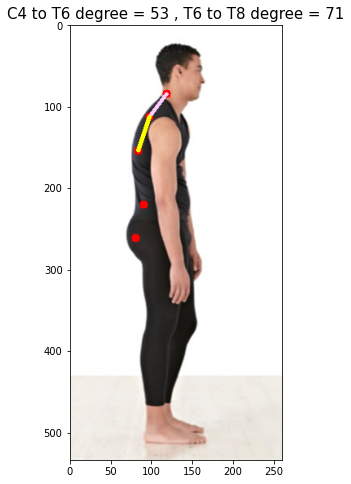

In [ ]:
plt.figure(figsize=(10,8))
Title = "C4 to T6 degree = " + str(v1_ang) + " , T6 to T8 degree = " + str(v2_ang)
result = spine_img.copy()

show_joint_annotation(result)
draw_line(result, spine_joints)

plt.title(Title,fontsize=15)
plt.imshow(result)
plt.show()